In [4]:
from etl.load_dataset import DatasetProcessor
import matplotlib.pyplot as plt
target_dir = '../test_files/TOGETHER'
dp = DatasetProcessor(target_dir)

In [146]:
import numpy as np
import os
import pandas as pd

class DatasetProcessor:
    def __init__(self, target_directory, image_extensions=('jpg'), annotation_extensions=('json'), id_prefix_size=10):
        self.target_directory = target_directory
        self.image_extensions = image_extensions
        self.annotation_extension = annotation_extensions
        # We assume that the patient id is encoded in the first id_prefix_size numbers of each file
        self.id_prefix_size = id_prefix_size
        self.dataset_dictionary = self._load_file_names()

    def _load_file_names(self):
        dataset_files = sorted(os.listdir(self.target_directory))
        json_names = [x for x in dataset_files if x.endswith('.json')]
        image_names = [x for x in dataset_files if x not in json_names]
        patient_ids = np.array([x[:self.id_prefix_size] for x in json_names])
        return {pid_: [[image_ for image_ in image_names if image_.startswith(pid_)],
                       [json_ for json_ in json_names if json_.startswith(pid_)]] for pid_ in patient_ids}

    # bbox, eggim in bbox, landmark
    def process_json(self, directory):  # TODO: test this
        with open(directory, 'r') as file:
            data = json.load(file)
        dict_parameters = {}
        for instance in data['instances']:
            if instance['className'] == 'EGGIM in the FULL Anatomical Location':
                dict_parameters['eggim_global'] = int(instance['attributes'][0]['name'])
            if instance['className'] == 'EGGIM in Target Area - Square':
                dict_parameters['eggim_square'] = int(instance['attributes'][0]['name'])
            if instance['className'] == 'Anatomical Location':
                dict_parameters['landmark'] = str(instance['attributes'][0]['name'])
            if instance["type"] == "bbox" and "points" in instance:
                points = instance["points"]
                left = points["x1"]
                top = points["y1"]
                right = points["x2"]
                bottom = points["y2"]
                dict_parameters['bbox'] = [round(left), round(top), round(right), round(bottom)] # plt.imshow(np.array(image)[round(y1):round(y2), round(x1):round(x2), :])
        return dict_parameters

    def process(self):
        dataset_info = []
        for patient, (images, jsons) in self.dataset_dictionary.items():
            for x, y in zip(images, jsons):
                annotation_data = self.process_json(os.path.join(self.target_directory, y))
                annotation_data['image_directory'] = os.path.join(self.target_directory, x)
                dataset_info.append(annotation_data)
        return pd.DataFrame(dataset_info)

target_dir = '../test_files/TOGETHER'
dp = DatasetProcessor(target_dir)
file_tensor = dp.process()

In [148]:
print(file_tensor)

                   bbox  eggim_global  eggim_square  \
0  [221, 136, 445, 360]             1             1   
1  [226, 216, 450, 441]             2             2   
2  [207, 126, 431, 350]             2             2   
3  [268, 145, 492, 369]             2             2   

                                      landmark  \
0  ix. distal lesser curvature in retroflexion   
1               viii. incisura in retroflexion   
2       vi. proximal antrum - lesser curvature   
3               viii. incisura in retroflexion   

                                    image_directory  
0  ../test_files/TOGETHER/20190927085204439.jpg.jpg  
1  ../test_files/TOGETHER/20190927113819624.jpg.jpg  
2      ../test_files/TOGETHER/20240117161144440.jpg  
3      ../test_files/TOGETHER/20240123103123152.jpg  


In [129]:
from PIL import Image

file_name = file_tensor[0][0]
crop = tuple(file_tensor[0][1]['bbox'])
image = Image.open(file_name)

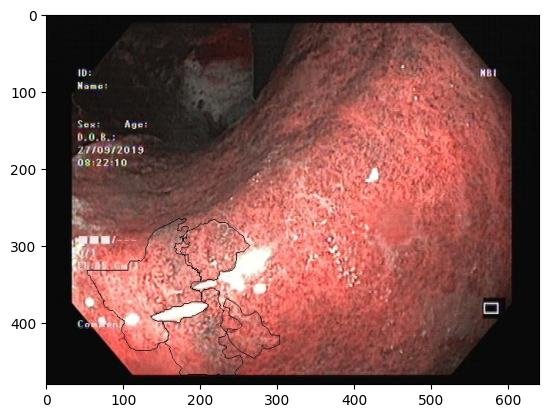

In [130]:
plt.imshow(image)

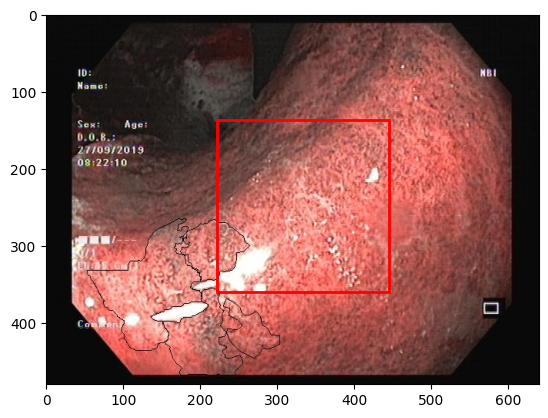

In [126]:
cropped_image = image.crop(crop)
x1, y1 = 221.16, 135.67
x2, y2 = 445.34, 359.85
rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', facecolor='none', linewidth=2)
rect = plt.Rectangle((round(x1), round(y1)), round(x2-x1), round(y2-y1), edgecolor='red', facecolor='none', linewidth=2)
plt.imshow(image)
plt.gca().add_patch(rect)

In [123]:
x1, y1 = int(221.16), int(135.67)
x2, y2 = int(445.34), round(359.85)
x1, y1, x2, y2

(221, 135, 445, 360)

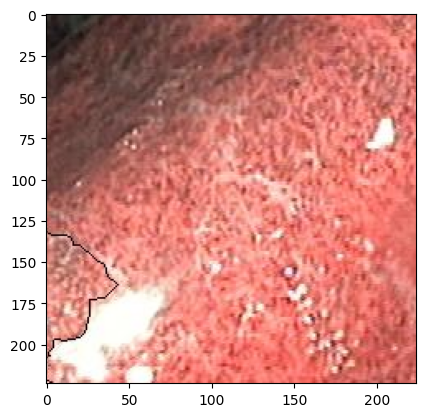

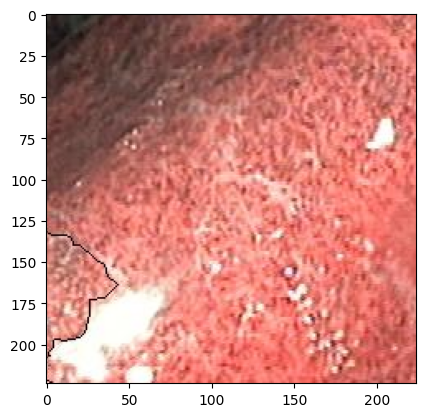

In [112]:
plt.imshow(cropped_image)

In [13]:
file_tensor[:, 1]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b'../test_files/TOGETHER/20190927085204439.jpg.json',
       b'../test_files/TOGETHER/20190927113819624.jpg.json',
       b'../test_files/TOGETHER/20240117161144440.jpg.json',
       b'../test_files/TOGETHER/20240123103123152.jpg.json'], dtype=object)>

In [86]:
import json
from PIL import Image
def load_and_preprocess_image(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        return image

def load_and_process_json(json_path):
    json_path = json_path.numpy().decode('utf-8')
    with open(json_path, 'r') as file:
        data = json.load(file)
    for instance in data['instances']:
        if instance["type"] == "bbox" and "points" in instance:
            points = instance["points"]
            left = points["x1"]
            top = points["y1"]
            right = points["x2"]
            bottom = points["y2"]
            return  tf.constant([left, top, right, bottom])

def get_data(file):
    image, annotation = file[0], file[1]
    x, y = load_and_preprocess_image(image), load_and_process_json(annotation)
    print(x)
    print(y)
    x =  tf.keras.preprocessing.image.array_to_img(x)

    cropped_image = x[bottom:top, left:right, :]
    # 231.2
    return cropped_image, y
img_processed = tf.map_fn(load_and_preprocess_image, file_tensor[:, 0 ], dtype=tf.uint8)
json_coords = tf.map_fn(load_and_process_json, file_tensor[:, 1], dtype=tf.float32)
dataset = tf.data.Dataset.from_tensor_slices(file_tensor)
dataset.map(get_data, tf.data.AUTOTUNE)


AttributeError: in user code:

    File "/var/folders/cr/qd8xdw991dv9ypjzzwsktpqc0000gn/T/ipykernel_6558/2536814566.py", line 23, in get_data  *
        x, y = load_and_preprocess_image(image), load_and_process_json(annotation)
    File "/var/folders/cr/qd8xdw991dv9ypjzzwsktpqc0000gn/T/ipykernel_6558/3269044588.py", line 9, in load_and_process_json  *
        json_path = json_path.numpy().decode('utf-8')

    AttributeError: 'Tensor' object has no attribute 'numpy'


In [80]:
json_coords


<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[221.16, 135.67, 445.34, 359.85],
       [226.09, 216.48, 449.77, 440.59],
       [207.14, 125.65, 431.36, 349.88],
       [268.03, 144.97, 492.25, 369.19]], dtype=float32)>

In [ ]:
 with open(json_file_path, 'r') as file:


    # Extraire le nom de l'image originale en remplaçant l'extension .json par .jpg
    image_name = os.path.splitext(os.path.basename(json_file_path))[0] + '.jpg'
    image_path = os.path.join(images_folder_path, image_name)

    # Charger l'image originale
    if not os.path.exists(image_path):
        print(f"Image originale non trouvée: {image_path}")
        return

    print(f"Image originale trouvée: {image_path}")
    image = Image.open(image_path)

    # Découper les régions définies par les boîtes englobantes (bbox)
    for instance in data["instances"]:
        if instance["type"] == "bbox" and "points" in instance:
            points = instance["points"]
            print(f"Coordonnées bbox trouvées pour {image_name}: {points}")
            left = points["x1"]
            top = points["y1"]
            right = points["x2"]
            bottom = points["y2"]

In [ ]:
def process_json_file(json_file_path, images_folder_path, cropped_output_folder):
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    # Extraire le nom de l'image originale en remplaçant l'extension .json par .jpg
    image_name = os.path.splitext(os.path.basename(json_file_path))[0] + '.jpg'
    image_path = os.path.join(images_folder_path, image_name)

    # Charger l'image originale
    if not os.path.exists(image_path):
        print(f"Image originale non trouvée: {image_path}")
        return

    print(f"Image originale trouvée: {image_path}")
    image = Image.open(image_path)

    # Découper les régions définies par les boîtes englobantes (bbox)
    for instance in data["instances"]:
        if instance["type"] == "bbox" and "points" in instance:
            points = instance["points"]
            print(f"Coordonnées bbox trouvées pour {image_name}: {points}")
            left = points["x1"]
            top = points["y1"]
            right = points["x2"]
            bottom = points["y2"]

            # Découper et sauvegarder la région
            cropped_image = image.crop((left, top, right, bottom))
            cropped_image_name = os.path.splitext(os.path.basename(json_file_path))[0] + f"_cropped_{instance['id']}.jpg"
            #cropped_image_name = os.path.splitext(os.path.basename(json_file_path))[0] + f"_cropped_{instance['id']}"
            cropped_image_path = os.path.join(cropped_output_folder, cropped_image_name)
            cropped_image.save(cropped_image_path)
        else:
            print(f"Aucune coordonnée bbox trouvée pour {image_name} dans {json_file_path}")



In [ ]:
img = ['../test_files/TOGETHER/20190927085204439.jpg.jpg', '../test_files/TOGETHER/20240117161144440.jpg']


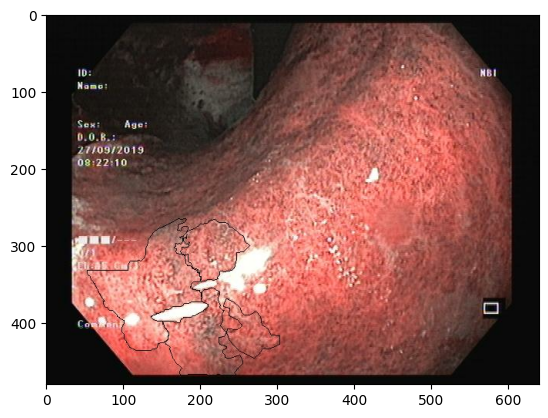

In [ ]:
plt.imshow(img_processed)